In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
import string
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus']=False

path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

## good, bad 리뷰 나누고 TOP10 키워드 빈도수 세기

In [ ]:
gg_ic = pd.read_csv('data/충남.csv')

In [231]:
gg_ic.head(3)

,region,hotel_name,services,location,star&reviews,good,bad,깨끗
0,충남,쏠레르 호텔,"['피트니스', '미니바', '와이파이', '욕실용품', '레스토랑', '금연', ...",충남 보령시 신흑동 2270-2,"[[4.0, '20시간 전', '가성비가 좋고 뷰맛집이며 백사장 접근성이 좋아 어린...",가성비가 좋고 뷰맛집이며 백사장 접근성이 좋아 어린이 동반 가족분들께 최고입니다 전...,문열고 들어서는 순간 아저씨 냄새가 났어요😅화장실 컨디션은 여기저기 곰팡이와수건도 ...,10
1,충남,천안 더메인즈호텔,"['와이파이', '욕실용품', '레스토랑', '금연', 'TV', '에어컨', '냉...",충남 천안시 동남구 청당동 526,"[[5.0, '1일 전', '천안 시험때문에 급하게 방문하였는데\n객실청결하고 카운...",천안 시험때문에 급하게 방문하였는데객실청결하고 카운터 친절하시고 다좋았습니다덕분에 ...,그냥 싼맛에 가는 모텔급 숙소먼지도 많고 냄새도 나고 불친절함이불하나만 추가해 달랬...,12
2,충남,보령 호텔 그랜드 베이,"['와이파이', '욕실용품', '금연', 'TV', '엘레베이터', '에어컨', '...",충남 보령시 궁촌동 342-3,"[[5.0, '12시간 전', '좋았어요 추천합니다 !\n(근데 아고다 예약이 더 ...",좋았어요 추천합니다 근데 아고다 예약이 더 싸요 ㅋ 청결하고 깔끔해서 만족합니다 3...,,19


In [219]:
def goodbad(df):
    # 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    def remove_punctuation(text):
        return ''.join([i for i in text if i not in string.punctuation])
        
    df['good'] = pd.Series(dtype=str)
    df['bad'] = pd.Series(dtype=str)
    # 모든 행을 돌리기
    for i in range(len(df)):
        # i행의 모든 평점, 리뷰
        list = eval(df.loc[i]['star&reviews'])
        go_list = []
        ba_list = []
        # 모든 리뷰 돌리기
        for hotel in range(len(list)):
            # 별점이 3점 이상 -> good
            if eval(df.loc[i]['star&reviews'])[hotel][0] >= 3.0:
                go_list.append(eval(df.loc[i,'star&reviews'])[hotel][2]) 
                
            # 별점이 3점 이하 -> bad
            elif eval(df.loc[i]['star&reviews'])[hotel][0] <= 3.0:
                ba_list.append(eval(df.loc[i,'star&reviews'])[hotel][2])
        go_list_join = ' '.join(go_list) 
        ba_list_join = ' '.join(ba_list)
        good_list_join = remove_punctuation(go_list_join)
        bad_list_join = remove_punctuation(ba_list_join)
        
        good_list_join =good_list_join.replace('\n', '')
        bad_list_join = bad_list_join.replace('\n', '')
        
        df.loc[i, 'good'] = ''.join(good_list_join)
        df.loc[i, 'bad'] = ''.join(bad_list_join)

In [226]:
# 키워드 개수 세기
def count_keyword(df, keyword):
    df[keyword] = pd.Series(dtype=str)
    for i in range(len(df)):
        count = df.loc[i,'good'].count(keyword)
        df.loc[i,keyword] = count

In [220]:
goodbad(gg_ic)

In [227]:
count_keyword(gg_ic,'깨끗')

------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
for i in range(len(gg_ic)):
    list = eval(gg_ic['star&reviews'].iloc[i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            reviews_list = list[hotel]
            if reviews_list[0] == 3.5:
                lists.append(reviews_list[2])

In [18]:
df_sr = pd.DataFrame(gg_ic['star&reviews'])
lists = []
bad_list= []
# 각 행에 대해 반복
for i in range(len(df_sr)):
    list = eval(df_sr['star&reviews'].iloc[i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            reviews_list = list[hotel]
            if reviews_list[0] == 3.5:
                lists.append(reviews_list[2])
len(lists)

520

In [13]:
gg_ic.head(3)

,region,hotel_name,services,location,star&reviews
0,충남,쏠레르 호텔,"['피트니스', '미니바', '와이파이', '욕실용품', '레스토랑', '금연', ...",충남 보령시 신흑동 2270-2,"[[4.0, '20시간 전', '가성비가 좋고 뷰맛집이며 백사장 접근성이 좋아 어린..."
1,충남,천안 더메인즈호텔,"['와이파이', '욕실용품', '레스토랑', '금연', 'TV', '에어컨', '냉...",충남 천안시 동남구 청당동 526,"[[5.0, '1일 전', '천안 시험때문에 급하게 방문하였는데\n객실청결하고 카운..."
2,충남,보령 호텔 그랜드 베이,"['와이파이', '욕실용품', '금연', 'TV', '엘레베이터', '에어컨', '...",충남 보령시 궁촌동 342-3,"[[5.0, '12시간 전', '좋았어요 추천합니다 !\n(근데 아고다 예약이 더 ..."


In [14]:
df_sr = pd.DataFrame(gg_ic[gg_ic['region']=='경기']['star&reviews'])
df_sr.head(3)

,star&reviews
150,"[[5.0, '3일 전', '수학여행 철이라서 강제 관리 당했으나.. 미리 안내도 ..."
151,"[[5.0, '1일 전', '주변에 아이 놀곳 칮았다가 가장 깔끔하고 조식도 서비스..."
152,"[[5.0, '8시간 전', '깨끗하고 조용합니다\n너무좋습니다'], [5.0, '..."


In [ ]:
# 긍정 / 부정 나누기

good_list = []
bad_list= []
# 각 행에 대해 반복
for i in range(len(df_sr)):
    list = eval(df_sr['star&reviews'][i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            reviews_list = list[hotel]
            if reviews_list[0] >= 3:
                good_list.append(reviews_list[2])
            elif  reviews_list[0] <=3:
                bad_list.append(reviews_list[2])

print(f'good:{good_list[0]}\nbad:{bad_list[0]}')

In [ ]:
good_list_join = ' '.join(good_list)
bad_list_join = ' '.join(bad_list)

# 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(text):
    return ''.join([i for i in text if i not in string.punctuation])
    
good_list_join = remove_punctuation(good_list_join)
bad_list_join = remove_punctuation(bad_list_join)

good_list_join =good_list_join.replace('\n', '').replace(' ', '')
bad_list_join = bad_list_join.replace('\n', '').replace(' ', '')

In [ ]:
good_list_join

In [ ]:
# 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가

stopwords_kr = pd.read_csv('한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
stopwords_kr.loc[len(stopwords_kr)] = '호텔'

In [ ]:
# 단어 토큰화
okt = Okt()
word_tokens_good = okt.pos(good_list_join)
word_tokens_bad = okt.pos(bad_list_join)

In [ ]:
# 불용어 제거 / tag이용해서 'Noun'만 추출가능
token_rv_good = [word for word, tag in word_tokens_good if len(word) > 1 if word not in stopwords_kr]
token_rv_bad = [word for word, tag in word_tokens_bad if len(word) > 1 if word not in stopwords_kr]

In [ ]:
freq_good = pd.DataFrame(pd.Series(Counter(token_rv_good)).sort_values(ascending=False), columns=['freq'])
freq_bad = pd.DataFrame(pd.Series(Counter(token_rv_bad)).sort_values(ascending=False), columns=['freq'])

In [ ]:
good_list_join = ' '.join(token_rv_good)
bad_list_join = ' '.join(token_rv_bad)

In [ ]:
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 긍정 워드클라우드
wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(good_list_join)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(f"긍정 키워드", fontsize=16)
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------

## 함수화

In [ ]:
def goodbad_wordcloud(df, region): 

    df_sr = pd.DataFrame(df[df['region']==region]['star&reviews'])
    good_list = []
    bad_list= []
    # 각 행에 대해 반복
    for i in range(len(df_sr)):
        list = eval(df_sr['star&reviews'][i])
        for hotel in range(len(list)):
                # 'star&reviews' 열의 값을 평가하고 리스트로 변환
                reviews_list = list[hotel]
                if reviews_list[0] >= 3:
                    good_list.append(reviews_list[2])
                elif  reviews_list[0] <=3:
                    bad_list.append(reviews_list[2])

    # good / bad 별 review 합치기
    good_list_join = ' '.join(good_list)
    bad_list_join = ' '.join(bad_list)
    
    # 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    def remove_punctuation(text):
        return ''.join([i for i in text if i not in string.punctuation])
    good_list_join =good_list_join.replace('\n', '').replace(' ', '')
    bad_list_join = bad_list_join.replace('\n', '').replace(' ', '')
        
    good_list_join = remove_punctuation(good_list_join)
    bad_list_join = remove_punctuation(bad_list_join)
    
    # 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가
    stopwords_kr = pd.read_csv('한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
    stopwords_kr = list(stopwords_kr['stopwaords'])

    # 단어 토큰화
    okt = Okt()
    word_tokens_good = okt.pos(good_list_join)
    word_tokens_bad = okt.pos(bad_list_join)
    
    # 불용어 제거 / tag이용해서 'Noun'만 추출가능
    
    token_rv_good = [word for word, tag in word_tokens_good if len(word) > 1 if word not in stopwords]
    token_rv_bad = [word for word, tag in word_tokens_bad if len(word) > 1 if word not in stopwords]
    freq_good = pd.DataFrame(pd.Series(Counter(token_rv_good)).sort_values(ascending=False), columns=['freq'])
    freq_bad = pd.DataFrame(pd.Series(Counter(token_rv_bad)).sort_values(ascending=False), columns=['freq'])

    good_list_join = ' '.join(token_rv_good)
    bad_list_join = ' '.join(token_rv_bad)

    font_path = 'C:/Windows/Fonts/malgun.ttf'
    
    # 긍정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(good_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 긍정 키워드", fontsize=16)
    plt.show()
    
    # 부정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(bad_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 부정 키워드", fontsize=16)
    plt.show()
    
    return freq_good, freq_bad

In [ ]:
good, bad = goodbad_wordcloud(gg_ic,'경기')

In [ ]:
good

In [ ]:
bad

--------------------------------------------------------------------------------------------------------------------------------------------------

## 함수 분할

In [19]:
def tokens(df,region):
    df_sr = pd.DataFrame(df[df['region']==region]['star&reviews'])
    good_list = []
    bad_list= []
    # 각 행에 대해 반복
    for i in range(len(df_sr)):
        list = eval(df_sr['star&reviews'].iloc[i])
        for hotel in range(len(list)):
                # 'star&reviews' 열의 값을 평가하고 리스트로 변환
                reviews_list = list[hotel]
                if reviews_list[0] >= 3:
                    good_list.append(reviews_list[2])
                elif  reviews_list[0] <=3:
                    bad_list.append(reviews_list[2])

    # good / bad 별 review 합치기
    good_list_join = ' '.join(good_list)
    bad_list_join = ' '.join(bad_list)
    
    # 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    def remove_punctuation(text):
        return ''.join([i for i in text if i not in string.punctuation])
    good_list_join =good_list_join.replace('\n', '').replace(' ', '')
    bad_list_join = bad_list_join.replace('\n', '').replace(' ', '')
        
    good_list_join = remove_punctuation(good_list_join)
    bad_list_join = remove_punctuation(bad_list_join)
    
    # 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가
    stopwords_kr = pd.read_csv('한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
    stopwords_kr.loc[len(stopwords_kr)] = '호텔'

    # 단어 토큰화
    okt = Okt()
    word_tokens_good = okt.pos(good_list_join)
    word_tokens_bad = okt.pos(bad_list_join)

    return word_tokens_good, word_tokens_bad

In [90]:
def remove_nu(word_tokens_good, word_tokens_bad):

    # 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가
    stopwords_kr = pd.read_csv('data/한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
    stopwords_kr.loc[len(stopwords_kr)] = '호텔'
    stopwords = stopwords_kr['휴'].tolist()
    
    # 불용어 제거 / tag이용해서 'Noun'만 추출가능
    token_rv_good = [word for word, tag in word_tokens_good if len(word) > 1 if word not in stopwords]
    token_rv_bad = [word for word, tag in word_tokens_bad if len(word) > 1 if word not in stopwords]
    freq_good = pd.DataFrame(pd.Series(Counter(token_rv_good)).sort_values(ascending=False), columns=['freq'])
    freq_bad = pd.DataFrame(pd.Series(Counter(token_rv_bad)).sort_values(ascending=False), columns=['freq'])

    good_list_join = ' '.join(token_rv_good)
    bad_list_join = ' '.join(token_rv_bad)

    return good_list_join, bad_list_join, freq_good, freq_bad

In [21]:
def word_colud(good_list_join,bad_list_join):
    font_path = 'C:/Windows/Fonts/malgun.ttf'
    
    # 긍정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(good_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 긍정 키워드", fontsize=16)
    plt.show()
    
    # 부정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(bad_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 부정 키워드", fontsize=16)
    plt.show()

## TEST

In [22]:
gg_ic = pd.read_csv('df_gg_ic.csv')

In [23]:
good, bad = tokens(gg_ic,'충남')

In [87]:
bad_adj =[]
for word, tag in bad:
    if tag == 'Adjective':
        bad_adj.append(word)
v = ''.join(bad_adj)
v

'저렴하게만족하고안되고많고불친절함안되서짜증남눈부셔서야함좋습니다친절하네요안되구요불친절해요시끄러운없고당연히급하게입니다넓고있습니다간단한가능해좋게있어편리했습니다야할거같습니다애매해서불편합니다만족스러울거같습니다좋아요깨끗한건기대히면안될것같고요좋을것같아요친절하셔서좋아요아까워요눅눅하고기대했는데안좋은어려운것은안좋아서스럽네요상당히나빴던건아쉬워요있는듯그래괜찮았고좋은많고무심해서아팠어요많고같았습니다괜찮았지만있었습니다친절하게나쁘진아쉬웠지만심하긴간지럽고힘드네요없다네요같습니다그렇있었음에도이렇다솔직히필요합니다없어서좋고넓긴오래되서지저분하고없습니다있는더러워서가까워서좋았어요더러워서시커멓게새까매졌어요조용히좋았습니다많아힘들었어요되는더워서건조하고아니라불편했어요많고힘들었네요미어다른데같아요죄송하지만입니다멀끔하다기대하면서좋지이상했습니다엄청난줄심합니다밤늦게검은있었습니다다행히도친절하게같습니다청결해서입니다있으면어떻게같은안되서편히없음많음아닌데좋네요만족하나많아서착하지칼칼해지는아니다싶어같은이상하다고거실에괜찮을듯청결하지못해친절하고없음없음입니다있는거아니고이런게있는데어떻게아니라없는불쾌했습니다입니다안되고지저분한입니계신다같다인하며높은없냐고없다나쁘다아닌인했었다안되어있다많은것깨끗했다는게더러웠다면천합니다입니다주말입니다없는불편합니다좋았불친절한것같내여많았고실망했습니다친절하고변해없을거같습니다먼불편하다고아쉬웠습니다적당했습니다딱히없고좁은없습니다없어요없습니다높은거라따뜻했는데있던아니라심각한건안되는데있네요너무하지만여전하고요괜찮다낡은거괜찮다괜찮다미지근한미지근한괜찮다하는지저분해서높은없음야한다면이런같은데괜찮앗아요심하네요없고더워더워같더라구요불쾌한어때이어때급히급히굉장히오래되었있고음침한없고야합니다야해서좋고좋고그래요좋아요오래되서많습니다입니다얇아요아닌데야해서같따뜻한미지근한오래된없고없고있는아쉽습니다차갑고가아닌듯이런있고따뜻한안되었어요없음없음입니다괜찮을것같아요박했는데입니다왠만해안좋은다릅니다낡디낡은전기더러운끈적끈적한입니다간단한뻔했어요친절했지만시급합니다을씨년스럽고원치않고박했는데더러워서추워없었습니다슬프네요입니다없었다는데안좋은부족하다고많아서없어서전화해야계신전화해야하는데불편

In [106]:
noun = []
for word, tag in bad:
    if tag == 'Noun':
        noun.append((word, tag))
    elif tag == 'Adjective':
        if word in ['불친절','시끄','불편','눅눅','간지럽','지저분','더러워','건조','청결','좁','낡','오래']:
            noun.append((word, tag))
noun

[('열', 'Noun'),
 ('순간', 'Noun'),
 ('아저씨', 'Noun'),
 ('냄새', 'Noun'),
 ('화장실', 'Noun'),
 ('컨디션', 'Noun'),
 ('여기저기', 'Noun'),
 ('곰팡이', 'Noun'),
 ('수건', 'Noun'),
 ('좀', 'Noun'),
 ('냄새', 'Noun'),
 ('급', 'Noun'),
 ('예약', 'Noun'),
 ('거', 'Noun'),
 ('저', 'Noun'),
 ('일박', 'Noun'),
 ('묵고', 'Noun'),
 ('방음', 'Noun'),
 ('그냥', 'Noun'),
 ('맛', 'Noun'),
 ('모텔', 'Noun'),
 ('숙소', 'Noun'),
 ('먼지', 'Noun'),
 ('냄새', 'Noun'),
 ('도나', 'Noun'),
 ('이불', 'Noun'),
 ('만추', 'Noun'),
 ('가해', 'Noun'),
 ('마저', 'Noun'),
 ('도안', 'Noun'),
 ('방음', 'Noun'),
 ('옆방', 'Noun'),
 ('아저씨', 'Noun'),
 ('신음', 'Noun'),
 ('소리', 'Noun'),
 ('맞은편', 'Noun'),
 ('롯데', 'Noun'),
 ('시네마', 'Noun'),
 ('간판', 'Noun'),
 ('때문', 'Noun'),
 ('암막', 'Noun'),
 ('커튼', 'Noun'),
 ('여행', 'Noun'),
 ('블로거', 'Noun'),
 ('로써', 'Noun'),
 ('최악', 'Noun'),
 ('평가', 'Noun'),
 ('시설', 'Noun'),
 ('위치', 'Noun'),
 ('청결', 'Noun'),
 ('모두', 'Noun'),
 ('다만', 'Noun'),
 ('직원', 'Noun'),
 ('서비스', 'Noun'),
 ('교육', 'Noun'),
 ('신경', 'Noun'),
 ('룸메', 'Noun'),
 ('이드', 'Noun'),
 ('땀', 'N

In [107]:
a,b,c,d = remove_nu(good,noun)

In [92]:
d[:50]

,freq
객실,17
직원,17
방문,16
냄새,15
바닥,15
청결,14
숙소,13
최악,12
청소,12
진짜,11


In [105]:
b

'순간 아저씨 냄새 화장실 컨디션 여기저기 곰팡이 수건 냄새 예약 일박 묵고 방음 그냥 모텔 숙소 먼지 냄새 도나 이불 만추 가해 도안 방음 옆방 아저씨 신음 소리 맞은편 롯데 시네마 간판 때문 암막 커튼 여행 블로거 최악 평가 시설 위치 청결 직원 서비스 교육 신경 룸메 이드 제일 프론트 전화 연결 진짜 체크 인하 공사 소리 지속 프론트 연락 확인 후연 락준 고해 연락 연락 공사 이해 상식 사소리 부공 소음 투숙 이해해 하나요 응대 서비스 최악 천안 구한 숙소 일본 이름 기대 욕조 사이즈 정도 프로젝트 설치 영화관 구도 사용 사용 음식 문해 거실 공간 모로 은의자 정도 거울 높이 화장 정말 이처 개선 친구 단체 자고 오기 객실 청소 신경 직원 객실 조식 석식 진짜 역대 노맛 요정 리뷰 보고 방문 후회 다미 바닥 관리 청결 관리 상태 실망 여행 사정 근방 묵고 가기 위해 기분 응대 직원 주방 주방 주방 청결 객실 바닥 얼룩 실외 테라스 객실 인조잔디 고정 무거 바람 석식 조식 평이 서기 대안 나름 히노끼 생각 모텔 생각 가격 청결 상태 엉망 곰팡이 먼지 바닥 유격 발가락 기본 바닥 먼지 곰팡이 때문 나발 사진 인스타 정도 실망 사람 전반 청결 컨디션 노후 먼지 샤워 부스 물때 부분 대해 요청 응대 기분 시작 가족 아기 어른 피부 트러블 워터파크 때문 이유 고생 워터파크 락스 냄새 주차장 차라 주차장 문자 누가 안내 주차 응대 별로 동네 자주 가지 금연 객실 담배 냄새 입실 환기 새벽 세시 화재 경보 손님 대피 소동 공지 그냥 디다 환불 하니 리뷰 새벽 고생 한번 돈벌레 해충 작업 데스크 직원 그냥 체크아웃 시설 방충 인피니티 느낌 숙소 일출 일몰 숙소 추천 바닥 해수욕장 인지 바닥 모래 방이 커서 바닥 걸레질 바닥 먼지 난방 체적 난국 난방 조절 개학 전주 런가 사람 조식 음식 금방 오션 사람 수건 고담 다른사람 추천 숙소 시설 생각 청결 엉망 화장실 청결 면서 모텔 기분 화장실 쓰레기 곰팡이 샤워 커튼 유지 생각 냄새 그냥 야식 물병 뚜껑 침대 고베 마다 때

In [117]:
b_list = b.split()

In [118]:
b_list

['순간',
 '아저씨',
 '냄새',
 '화장실',
 '컨디션',
 '여기저기',
 '곰팡이',
 '수건',
 '냄새',
 '예약',
 '일박',
 '묵고',
 '방음',
 '그냥',
 '모텔',
 '숙소',
 '먼지',
 '냄새',
 '도나',
 '이불',
 '만추',
 '가해',
 '도안',
 '방음',
 '옆방',
 '아저씨',
 '신음',
 '소리',
 '맞은편',
 '롯데',
 '시네마',
 '간판',
 '때문',
 '암막',
 '커튼',
 '여행',
 '블로거',
 '최악',
 '평가',
 '시설',
 '위치',
 '청결',
 '직원',
 '서비스',
 '교육',
 '신경',
 '룸메',
 '이드',
 '제일',
 '프론트',
 '전화',
 '연결',
 '진짜',
 '체크',
 '인하',
 '공사',
 '소리',
 '지속',
 '프론트',
 '연락',
 '확인',
 '후연',
 '락준',
 '고해',
 '연락',
 '연락',
 '공사',
 '이해',
 '상식',
 '사소리',
 '부공',
 '소음',
 '투숙',
 '이해해',
 '하나요',
 '응대',
 '서비스',
 '최악',
 '천안',
 '구한',
 '숙소',
 '일본',
 '이름',
 '기대',
 '욕조',
 '사이즈',
 '정도',
 '프로젝트',
 '설치',
 '영화관',
 '구도',
 '사용',
 '사용',
 '음식',
 '문해',
 '거실',
 '공간',
 '모로',
 '은의자',
 '정도',
 '거울',
 '높이',
 '화장',
 '정말',
 '이처',
 '개선',
 '친구',
 '단체',
 '자고',
 '오기',
 '객실',
 '청소',
 '신경',
 '직원',
 '객실',
 '조식',
 '석식',
 '진짜',
 '역대',
 '노맛',
 '요정',
 '리뷰',
 '보고',
 '방문',
 '후회',
 '다미',
 '바닥',
 '관리',
 '청결',
 '관리',
 '상태',
 '실망',
 '여행',
 '사정',
 '근방',
 '묵고',
 '가기',
 '위해',
 '기분',
 '응대'

In [122]:
b_list = replace_word_list(['눅눅','낡','오래','좁'],'오래된', b_list)
b_list = replace_word_list(['청결','간지럽','지저분','더러워'],'청결', b_list)
b_list = replace_word_list(['불친절'],'불친절', b_list)
b_list = replace_word_list(['불편'],'불편', b_list)
b_list = replace_word_list(['시끄','소음','소란'],'소음', b_list)
b_list

TypeError: object of type 'NoneType' has no len()

In [97]:
a_list = a.split()

In [94]:
df_a = pd.DataFrame(a_list)

In [95]:
df_a.to_csv('a')

In [96]:
df_a.values.tolist()[:10]

[['가성'],
 ['좋고'],
 ['맛집'],
 ['백사'],
 ['접근성'],
 ['좋아'],
 ['어린이'],
 ['동반'],
 ['가족'],
 ['최고'],
 ['입니다전'],
 ['객실'],
 ['오션'],
 ['만족'],
 ['입니다'],
 ['오션'],
 ['엄청나요'],
 ['배트'],
 ['남호'],
 ['이안'],
 ['같은'],
 ['가을'],
 ['정도'],
 ['온돌방'],
 ['용했는'],
 ['데뷰'],
 ['진짜'],
 ['최고'],
 ['입니다'],
 ['생각'],
 ['방음'],
 ['폭죽'],
 ['소리'],
 ['도안'],
 ['온돌방'],
 ['이불'],
 ['매트'],
 ['조금'],
 ['더폭'],
 ['신하'],
 ['좋겠어요'],
 ['원래'],
 ['깨끗했는'],
 ['데리'],
 ['모델링'],
 ['비조'],
 ['식당'],
 ['객실'],
 ['컨시션'],
 ['고급스러워졌어요'],
 ['정말'],
 ['만족도'],
 ['침대'],
 ['매트리스'],
 ['진짜'],
 ['완전'],
 ['싸구려'],
 ['매트리스'],
 ['사람'],
 ['뒤척'],
 ['이기만'],
 ['해도'],
 ['꿀렁'],
 ['거리'],
 ['매트리스'],
 ['전체'],
 ['렁꿀렁'],
 ['아주'],
 ['좋습니다'],
 ['부모님'],
 ['모시'],
 ['좀더'],
 ['쾌적하고'],
 ['안락하고'],
 ['예약'],
 ['대단히'],
 ['만족스러워'],
 ['방문'],
 ['의사'],
 ['있고'],
 ['조식'],
 ['쁘띠'],
 ['있는'],
 ['만족스런'],
 ['식사'],
 ['추천'],
 ['객실'],
 ['화장실'],
 ['깔끔하고'],
 ['커튼'],
 ['자동'],
 ['오션'],
 ['멋지네요'],
 ['조식'],
 ['부페'],
 ['맛있었습니다'],
 ['두번째'],
 ['서비스'],
 ['컨디션'],
 ['위치'],
 ['만족'],
 ['대천'],
 ['지역'],
 ['숙소'],
 ['제일'

In [97]:
words = []
for i in df_a.values.tolist():
    word = i[0]
    words.append(word)
    text = ' '.join(words)

text
# range(len(df_a.values.tolist()))

'가성 좋고 맛집 백사 접근성 좋아 어린이 동반 가족 최고 입니다전 객실 오션 만족 입니다 오션 엄청나요 배트 남호 이안 같은 가을 정도 온돌방 용했는 데뷰 진짜 최고 입니다 생각 방음 폭죽 소리 도안 온돌방 이불 매트 조금 더폭 신하 좋겠어요 원래 깨끗했는 데리 모델링 비조 식당 객실 컨시션 고급스러워졌어요 정말 만족도 침대 매트리스 진짜 완전 싸구려 매트리스 사람 뒤척 이기만 해도 꿀렁 거리 매트리스 전체 렁꿀렁 아주 좋습니다 부모님 모시 좀더 쾌적하고 안락하고 예약 대단히 만족스러워 방문 의사 있고 조식 쁘띠 있는 만족스런 식사 추천 객실 화장실 깔끔하고 커튼 자동 오션 멋지네요 조식 부페 맛있었습니다 두번째 서비스 컨디션 위치 만족 대천 지역 숙소 제일 좋았어요 방문 예정 오션 좋고 시설 청결 상태 양호 화장실 무척 넓은데 해변 편하게 다만 서쪽 오후 햇살 무척 강하게 신랑 처음 깨끗하고 좋았어요 가구 갈색 종류 오래된 느낌 직원 친절하시고 괜찮았어요 오션 바다 정면 무념 무상 편하고 좋더라구요 보통 생수 개정 있는데 차용 양치 용두 단지 침대 매트리스 불편한거 좋은 여행 대천 레르 만선 호해 아이 있어 마루 바닥 깨끗하고 키즈 카페 좋더라구요 바로 해변 라서 체크 인하기전에 신나게 숙소 웰컴 맥주 객실 한잔 좋았어요 안될까 어린이날 모터쇼 행사 크게 있어서 예약 할인 쿠폰 대박 이예 모든 완벽한 숙소 입니다 강추 오션 일몰 보기 좋았습니다 가족 숙소 편안하게잘 이용 좋았습니다 시설 청결 직원 위치 등등 좋아요 방음 안됩니다 다른 소리 바다 풍경 석양 풍경 객실 좋았으며 편안하게 다다 치약 없으며 주차공간 부족해서 주차 거나 외출 시불 편합니다 방도 깔끔하고 좋습니다 서산 유기 방가 몇년 대천해수욕장 여행 숙소 리뷰 좋아 급하게 예약 최고 선택 요전 객실 오션 배정 객실 환상 객실 자마자 커튼 사이 파란 바다 영화 같았어요 객실 청결 좋고 바닥 난방 기도 답답하지 방음 또한 다른 소음 없어서 더없이 좋았어요 바다 레일바이크 가까워서 이용 편리했답니다 숙

### 같은 의미 단어 동일화

In [121]:
# 'aa'라는 단어가 들어간 문자열 찾아서 단어 통일 시키기

def replace_word(word, replace, text_list):
    for i in range(len(text_list)):
        if word in text_list[i]:
            text_list[i] = replace
    return text_list

In [120]:
def replace_word_list(word_list,replace,text_list):
    for i in word_list:
        replace_word(i,replace,text_list)

In [66]:
a_list = replace_word_list(['좋','괜찮','훌륭','만족'],'만족', a_list)

In [146]:
a_list = replace_word('만족도','만족', a_list)

In [145]:
a_list

['가격',
 '만족도',
 '맛집',
 '이며',
 '백사',
 '접근성',
 '어린이',
 '동반',
 '가족',
 '분들',
 '최고',
 '입니다전',
 '객실',
 '오션',
 '만족도',
 '입니다',
 '오션',
 '엄청나요',
 '배트',
 '남호',
 '이안',
 '온것',
 '같은',
 '가을',
 '정도',
 '이네',
 '온돌방',
 '용했는',
 '데뷰',
 '진짜',
 '최고',
 '입니다',
 '생각',
 '보다',
 '방음',
 '되는지',
 '폭죽',
 '소리',
 '도안',
 '들렸어요',
 '온돌방',
 '이불',
 '매트',
 '더폭',
 '신하',
 '만족도',
 '묵으러',
 '가겠습니다',
 '원래',
 '청결',
 '데리',
 '모델링',
 '에로',
 '비조',
 '식당',
 '객실',
 '컨시션',
 '만족도',
 '고급스러워졌어요',
 '정말',
 '만족도',
 '99',
 '모자란',
 '침대',
 '매트리스',
 'ㅠㅠ',
 '진짜',
 '완전',
 '싸구려',
 '매트리스',
 'ㅠㅠ',
 '사람',
 '뒤척',
 '이기만',
 '해도',
 '꿀렁',
 '거리',
 '탄것처럼',
 '매트리스',
 '전체',
 '가꿀',
 '렁꿀렁',
 'ㅠㅠ',
 '아주',
 '만족도',
 '부모님',
 '모시',
 '좀더',
 '쾌적하고',
 '안락하고',
 '쉼이',
 '될만',
 '찾다',
 '예약',
 '대단히',
 '만족도',
 '방문',
 '의사',
 '있고',
 '조식',
 '쁘띠',
 '서있을거다',
 '있는',
 '만족도',
 '식사',
 '였어여',
 '추천',
 '합니다',
 '객실',
 '화장실',
 '청결',
 '커튼',
 '자동',
 '열리는',
 '오션',
 '멋지네요',
 '조식',
 '부페',
 '맛있었습니다',
 '두번째',
 '왔는데',
 '너무',
 '쉬다',
 '갑니다',
 '서비스',
 '컨디션',
 '위치',
 '모든',
 '만족도',
 '대천',
 '지역',
 '숙소',
 '제일'

In [99]:
a_list = replace_word('깨끗','청결', a_list)
a_list = replace_word('깔끔','청결', a_list)
a_list = replace_word('가성','가격', a_list)
a_list = replace_word('가격','가격', a_list)
a_list = replace_word('좋','만족', a_list)
a_list = replace_word('괜찮','만족', a_list)
a_list = replace_word('훌륭','만족', a_list)

In [77]:
set(b_list)

{'창틀',
 '최악',
 '불친절',
 '보호',
 '외관',
 '없냐고',
 '우울',
 '환기',
 '친절하다는',
 '리뷰',
 '목적',
 '깨끗하지',
 '깨끗했어요',
 '아닙니다',
 '건조하니까',
 '스텐드',
 '냉장고',
 '상실',
 '괜찮을듯',
 '자체',
 '새벽',
 '같내여',
 '보시',
 '입구',
 '고글',
 '주말',
 '전화해야',
 '아줌마',
 '원치않고',
 '금연',
 '하이라이트',
 '안되어있다',
 '고간',
 '이제',
 '요구',
 '의욕',
 '영화관',
 '연락',
 '고정',
 '기절',
 '가시',
 '직원',
 '대쪽',
 '카펫',
 '체크',
 '의사',
 '검색',
 '높은',
 '틀림',
 '기본',
 '이월',
 '대안',
 '구매',
 '여자',
 '닌지',
 '세이',
 '인프라',
 '있던데',
 '입금',
 '도오',
 '점검',
 '면서',
 '조절',
 '모시',
 '필수',
 '빈대',
 '추워요',
 '그대로',
 '결론',
 '시기',
 '방도',
 '룸메',
 '실망',
 '여행',
 '고생',
 '물티슈',
 '만족하나',
 '티비',
 '자동',
 '테이블',
 '사생활',
 '되는',
 '반복',
 '오늘',
 '청결',
 '고요',
 '같은',
 '없어요',
 '전체',
 '행시',
 '루아',
 '작업',
 '대화',
 '이싼',
 '이유식',
 '비데',
 '별로',
 '인덕션',
 '완전',
 '프론트',
 '조식',
 '위해',
 '힘들었어요',
 '다릅니다',
 '는걸',
 '근방',
 '이간',
 '역사',
 '이런데',
 '안될것',
 '가성',
 '어르신',
 '같아요',
 '런트',
 '더워',
 '만족스러울거',
 '있는데',
 '같더라구요',
 '없었다는데',
 '도착',
 '악독',
 '없습니다',
 '진배',
 '대요',
 '좋아요',
 '문해',
 '젓가락',
 '도모',
 '이처',
 '자지',
 '백악관',
 '가깝습니다',
 '안

## 결과

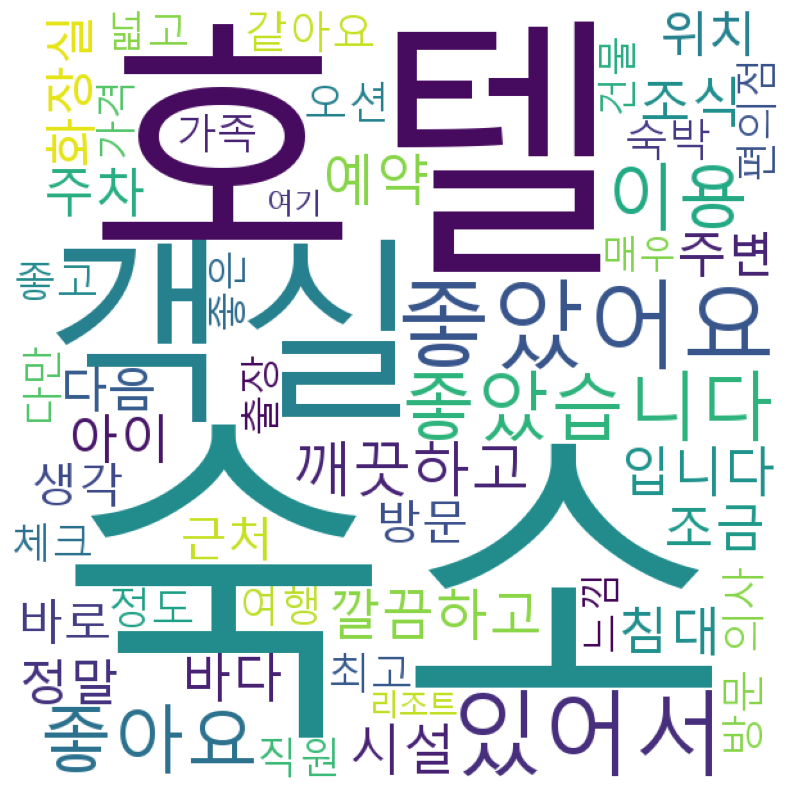

In [98]:
# 긍정 워드클라우드
font_path = 'C:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(width = 600, height = 600, max_words=50, font_path = font_path, background_color='white').generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# okt pos 확인하기(word_tokens_good, word_tokens_bad)
tokens(df,region)

# 불용어 처리 후 워드클라우드에 넣을 text문장으로 join (good_list_join, bad_list_join, freq_good, freq_bad)
remove_nu(word_tokens_good, word_tokens_bad)

# 워드 클라우드 하기
word_colud(good_list_join,bad_list_join)